# MNIST Digits MLP

A revisit of the MNIST Digits Recognition problem with MLP model.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from mltoolkit.utils import dump_keras_model

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

## Functions

In [22]:
def dump_array(dic:dict,path:str="Datasets\\Raw Data\\",fmt:str='csv',**kwargs):
    '''
    Dump multiple Series/DataFrames/2d-arrays as CSV/Parquet/Pickle format 
    at once.
    
    Parameters:
    ----------
    dic: dictionary
        Dictionary of the 2d-arrays/Series/DataFrame to be dumped.
        Key = filename, Value = 2d-arrays/Series/DataFrame
    path: str
        Path to dump the file(s)
    fmt: str {'csv','parquet','pkl'}
        File format to be stored.
    **kwargs
    '''
    assert fmt in ('csv','parquet','pkl')
    
    for filename,file in dic.items():
        if type(file) is np.ndarray or type(file) is pd.Series:
            file = pd.DataFrame(file)
        if type(file) is pd.DataFrame:
            if fmt == 'csv': file.to_csv(path+filename+".csv",**kwargs)
            elif fmt == 'parquet': file.to_parquet(path+filename+".parquet",**kwargs)
            elif fmt == 'pkl': file.to_pickle(path+filename+".pkl",**kwargs)
        else:
            raise TypeError("Only Series, DataFrame and nd-array are acceptable as the " +
                            "content of the passed in dictionary.")

## Loading Datasets

In [4]:
X_train_raw = joblib.load("Datasets\\X_train_raw.pkl")
y_train_raw = joblib.load("Datasets\\y_train_raw.pkl")
X_test_raw = joblib.load("Datasets\\X_test_raw.pkl")
y_test_raw = joblib.load("Datasets\\y_test_raw.pkl")
X_train_raw.shape,y_train_raw.shape,X_test_raw.shape,y_test_raw.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [5]:
X_train,X_valid,y_train,y_valid = train_test_split(X_train_raw,y_train_raw,test_size=5000,stratify=y_train_raw)
X_train.shape,X_valid.shape,y_train.shape,y_valid.shape

((55000, 784), (5000, 784), (55000,), (5000,))

In [6]:
X_test,y_test = X_test_raw.copy(),y_test_raw.copy()

## Scaling the Datasets

In [7]:
X_train /= 255
X_valid /= 255
X_test /= 255

### Saving Datasets

In [60]:
csvs = {
    "X_train":X_train,
    "X_valid":X_valid,
    "y_train":y_train,
    "y_valid":y_valid,
    "X_test":X_test,
    "y_test":y_test,
}
dump_array(csvs,"Datasets\\",'parquet')

## Training MLP

The initial model architecture before hyperparameters tuning is as shown in the image below:

<img src="Images/MNIST_Digits_MLP_Architecture_0.png" alt="drawing" width="400"/>

In [8]:
mnist_mlp = keras.Sequential([
    keras.layers.Flatten(input_shape=(784,),name='flatten'),
    keras.layers.Dense(784,activation='relu',name='hidden_1'),
    keras.layers.Dense(784,activation='relu',name='hidden_2'),
    keras.layers.Dense(10,activation='softmax',name='output'),
])

In [9]:
mnist_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden_1 (Dense)            (None, 784)               615440    
                                                                 
 hidden_2 (Dense)            (None, 784)               615440    
                                                                 
 output (Dense)              (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


In [10]:
learning_rates = np.logspace(-4,2,7)
losses = []
mnist_mlp_weights = mnist_mlp.get_weights()
mnist_mlp_early_stop = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
model_min_loss = None
min_loss = 99999
for lr in learning_rates:
    tf.keras.backend.clear_session()
    mnist_mlp.set_weights(mnist_mlp_weights)
    optimizer = keras.optimizers.SGD(learning_rate=lr)
    mnist_mlp.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    history = mnist_mlp.fit(X_train,y_train,batch_size=256,epochs=200,
                            callbacks=[mnist_mlp_early_stop],
                            validation_data=(X_valid,y_valid))
    model_loss = np.min(history.history['val_loss'])
    losses.append(model_loss)
    if model_loss < min_loss:
        min_loss = model_loss
        mnist_mlp.save("System\\model_min_loss.h5")

Epoch 1/200
215/215 [==============================] - 3s 7ms/step - loss: 2.3315 - accuracy: 0.1069 - val_loss: 2.3187 - val_accuracy: 0.1192
Epoch 2/200
215/215 [==============================] - 1s 6ms/step - loss: 2.3091 - accuracy: 0.1278 - val_loss: 2.2969 - val_accuracy: 0.1404
Epoch 3/200
215/215 [==============================] - 1s 6ms/step - loss: 2.2876 - accuracy: 0.1501 - val_loss: 2.2758 - val_accuracy: 0.1574
Epoch 4/200
215/215 [==============================] - 1s 6ms/step - loss: 2.2666 - accuracy: 0.1721 - val_loss: 2.2554 - val_accuracy: 0.1856
Epoch 5/200
215/215 [==============================] - 1s 6ms/step - loss: 2.2463 - accuracy: 0.1962 - val_loss: 2.2354 - val_accuracy: 0.2054
Epoch 6/200
215/215 [==============================] - 1s 6ms/step - loss: 2.2264 - accuracy: 0.2185 - val_loss: 2.2159 - val_accuracy: 0.2290
Epoch 7/200
215/215 [==============================] - 1s 6ms/step - loss: 2.2069 - accuracy: 0.2444 - val_loss: 2.1967 - val_accuracy: 0.2586

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

Unfortunately, we have trained our model until our GPU is out of memory.\
But luckily, with just the portion that we succesfully run, we can somehow identify the optimum learning rate already.\

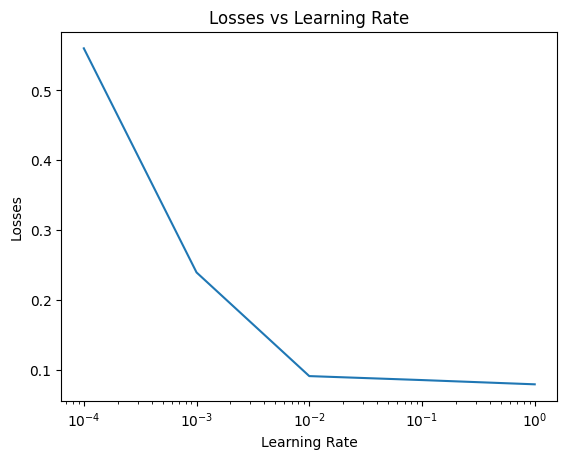

In [14]:
plt.plot(learning_rates[:5],losses)
plt.title("Losses vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Losses")
plt.xscale('log')

We can see that the elbow exists at learning rate = 0.01.\
We will use learning rate = 1.0 as the best learning rate in this case, since it still provides lower loss compared to 0.01.

We will also reload the optimal model with minimum loss that we saved earlier during the training.

### Best Model

The best model's illustration is shown in the image below:

<img src="Images/MNIST_Digits_MLP_Architecture_best.png" alt="drawing" width="400"/>

In [15]:
mnist_mlp_best = keras.models.load_model("System\\model_min_loss.h5")

### Test Accuracy

In [20]:
mnist_mlp_best_acc = mnist_mlp_best.evaluate(X_test,y_test,batch_size=64)
mnist_mlp_best_acc

157/157 [==============================] - 1s 5ms/step - loss: 0.0613 - accuracy: 0.9815


[0.061335302889347076, 0.9815000295639038]

We can achieve accuracy as high as 98% without even further fine tune the number of layers and number of neurons.

### Saving the Model

In [21]:
mnist_mlp_best_scores = {
    "mnist_mlp_best_acc":mnist_mlp_best_acc
}

In [24]:
dump_keras_model(mnist_mlp_best,filename="mnist_mlp_best",scores=mnist_mlp_best_scores)

INFO:tensorflow:Assets written to: Trained Models\2022-08-29_00-14-04_mnist_mlp_best\assets


## Conclusion

In addressing the memory error that I encountered during the iterative training phase to find the best learning rate, there are several ways that is potentially able to fix it.
1. Simply using a stronger hardware specs, GPU with larger memory.
2. Mini-batching the datasets into smaller batches before fitting into the model (due to tensorflow will store the whole dataset to the GPU memory regardless of batch_size in the .fit() method)
3. Reduce the dimensionality of the datasets with technique such as PCA so we can greatly reduce the number of features in the dataset.

But eitherway, with the best found learning rate, we are able to train a model that is very robust against test dataset, at 98% accuracy.